# Test Notebook to learn how to read in various tide gauge records

### Some sources of tide gauge data

https://www.psmsl.org/

http://www.ioc-sealevelmonitoring.org/

http://uhslc.soest.hawaii.edu/data/

### Load in some modules

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import matplotlib.dates as mdates

from tidegauge_functions import read_tidegauge_psmsl

# %matplotlib notebook
%matplotlib inline
# %matplotlib widget

### A place for function development
NOTE that the function below is the "test" function (notice different function name) used for development in this notebook.  Production function is loaded from  `tidegauge_functions.py`

In [2]:
def test_read_tidegauge_psmsl(path, columns=None):
    """
    Read and parse PSMSL tide gauge data

    CSV Columns:
        'YEAR', 'MONTH', 'DAY', 'SSH', possibly 'HOUR'

    Parameters
    ----------
    path : str
        Filesystem path to data file
    columns: List

    Returns
    -------
    pandas.DataFrame
        Gravity data indexed by datetime.
    """
    columns = ['YEAR', 'MONTH', 'DAY', 'SSH']

    df = pd.read_csv(path, header=None, engine='c')

#     print(f'len(df.columns): {len(df.columns)}')
#     print(f'len(columns): {len(columns)}')
    
    if len(df.columns) == len(columns):
#         columns += ['unknown']
        df.columns = ['YEAR', 'MONTH', 'DAY', 'SSH']
        dt = pd.to_datetime(df[['YEAR', 'MONTH', 'DAY']])
    else:
        df.columns = ['YEAR', 'MONTH', 'DAY', 'HOUR', 'SSH']
        dt = pd.to_datetime(df[['YEAR', 'MONTH', 'DAY', 'HOUR']])
        
    # missing data to NaNs
    df['SSH'] = df['SSH'].replace(-32767, np.nan)
    
    # create datetime index
    df.index = pd.DatetimeIndex(dt)
    
    
    return df

In [3]:
dir_in = 'data/tidegauge'
# file_in = 'h820'
file_in = 'd820'
ext = '.csv'

filepath = os.path.join(dir_in, file_in + ext)

df = read_tidegauge_psmsl(filepath)

In [4]:
df.describe()

,YEAR,MONTH,DAY,SSH
count,2158.000000,2158.000000,2158.000000,2005.000000
mean,2016.960612,6.528267,15.760426,4514.105237
std,1.753948,3.476244,8.794916,113.750938
min,2014.000000,1.000000,1.000000,4038.000000
25%,2015.000000,3.000000,8.000000,4444.000000
50%,2017.000000,7.000000,16.000000,4510.000000
75%,2018.000000,10.000000,23.000000,4576.000000
max,2020.000000,12.000000,31.000000,4982.000000


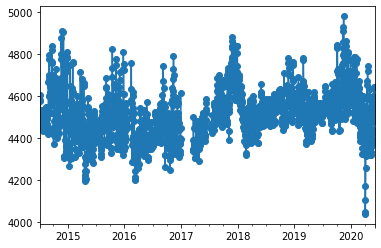

In [5]:
ax = df['SSH'].plot(marker='o')
# ax.set_xlim(pd.Timestamp('2015-08-01'), pd.Timestamp('2015-09-01'))
# ax.set_ylim(4300, 4600)

### Histogram

- What is the mean?
- Is distribution symmetric?

/Users/dporter/anaconda2/envs/py36/lib/python3.6/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/dporter/anaconda2/envs/py36/lib/python3.6/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


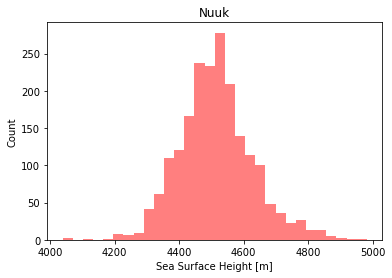

In [6]:
plt.figure(facecolor='white')
plt.hist(df['SSH'], bins=30, alpha=0.5,color='red')
plt.title('Nuuk');
plt.xlabel("Sea Surface Height [m]")
plt.ylabel("Count")
plt.show()

### Plotting using **matplotlib.pyplot** method instead of built-in Pandas
use `plt.plot()`

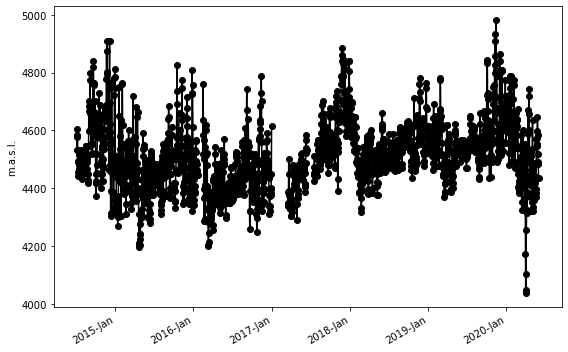

In [7]:
    # Set up
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(111)

# Plot
ln1 = ax.plot(df['SSH'], '-ok')

# Customize
ax.set_title('')
# ax.set_xlim([my_levels[0], my_levels[-1]])
# ax.set_ylim(my_plotmin, 0)
plt.ylabel('m.a.s.l.')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))
fig.autofmt_xdate()
plt.tight_layout()
plt.savefig(f'figs/test_tsplot_SSH_{file_in}.png')

### Plot each year on top of eachother
Do this by masking by `df.index.year`

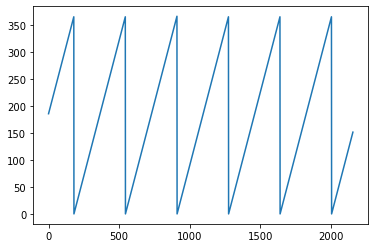

In [8]:
plt.plot(df.index.dayofyear)

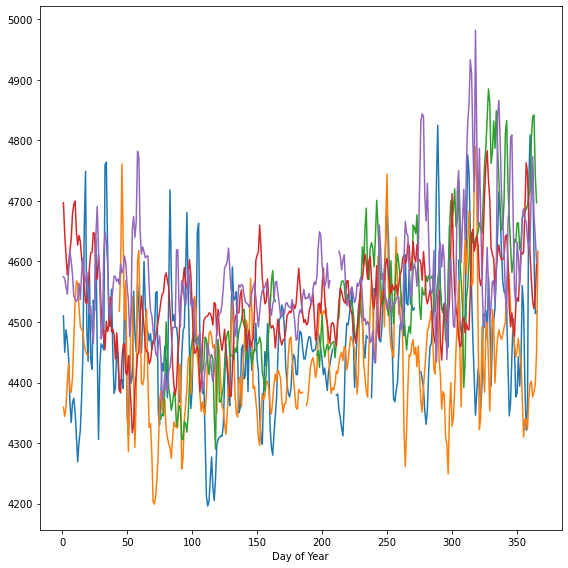

In [9]:
# Set up
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)

# Plot
ax.plot(df[df.index.year==2015].index.dayofyear, df[df.index.year==2015]['SSH'])
ax.plot(df[df.index.year==2016].index.dayofyear, df[df.index.year==2016]['SSH'])
ax.plot(df[df.index.year==2017].index.dayofyear, df[df.index.year==2017]['SSH'])
ax.plot(df[df.index.year==2018].index.dayofyear, df[df.index.year==2018]['SSH'])
ax.plot(df[df.index.year==2019].index.dayofyear, df[df.index.year==2019]['SSH'])
# ax.plot(df[df.index.year==2016]['SSH'])
plt.xlabel('Day of Year')
plt.tight_layout()

### Create some climatologies using `groupby` method
Monthly and Daily

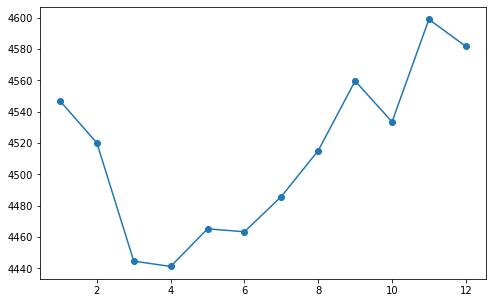

In [10]:
fig = plt.figure(figsize=(8,5))
monthly_climatology = df.groupby(df.index.month).mean()
monthly_climatology.SSH.plot(marker='o')


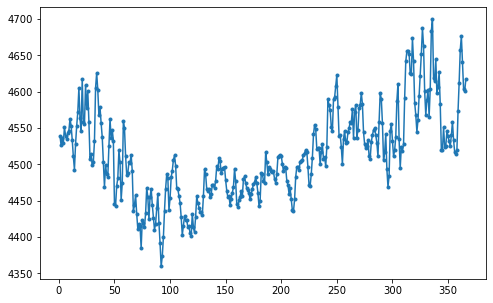

In [11]:
daily_climatology = df.groupby(df.index.dayofyear).mean() #aggregate({'SSH_DAILY_MEAN': 'mean',
#                                                             'SSH_DAILY_MAX': 'max',
#                                                             'SSH_DAILY_MIN': 'min'})
fig = plt.figure(figsize=(8,5))
daily_climatology.SSH.plot(marker='.')

### Standardize
Subtract the mean and divide by standard deviation

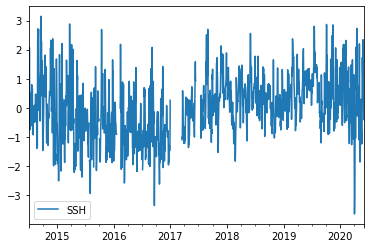

In [12]:
def standardize(x):
    return (x - x.mean())/x.std()

anomaly = df.groupby(df.index.month).transform(standardize)
anomaly.plot(y='SSH')

## Hourly data

In [13]:
file_in = 'h820'
ext = '.csv'

filepath = os.path.join(dir_in, file_in + ext)

hourly = test_read_tidegauge_psmsl(filepath)
hourly

,YEAR,MONTH,DAY,HOUR,SSH
2014-07-04 12:00:00,2014,7,4,12,4647.0
2014-07-04 13:00:00,2014,7,4,13,5141.0
2014-07-04 14:00:00,2014,7,4,14,5426.0
2014-07-04 15:00:00,2014,7,4,15,5444.0
2014-07-04 16:00:00,2014,7,4,16,5229.0
...,...,...,...,...,...
2020-05-31 19:00:00,2020,5,31,19,5214.0
2020-05-31 20:00:00,2020,5,31,20,4781.0
2020-05-31 21:00:00,2020,5,31,21,4229.0
2020-05-31 22:00:00,2020,5,31,22,3722.0


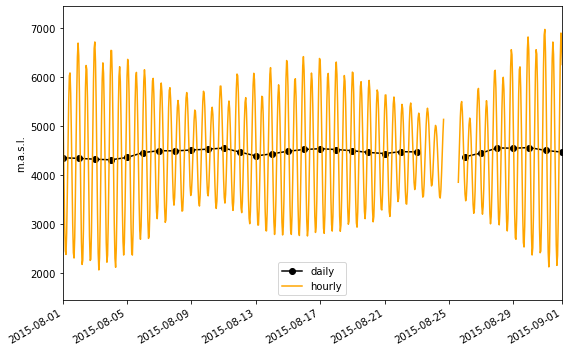

In [14]:
# Set up
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(111)

# Plot
ln1 = plt.plot(df['SSH'], '-ok', label='daily')
ln2 = plt.plot(hourly['SSH'], color='orange', label='hourly')

# Customize
ax.set_title('')
ax.set_xlim(pd.Timestamp('2015-08-01'), pd.Timestamp('2015-09-01'))
# ax.set_ylim(my_plotmin, 0)
plt.ylabel('m.a.s.l.')
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))
fig.autofmt_xdate()
plt.legend()
plt.tight_layout()
plt.savefig(f'figs/test_tsplot_SSH_{file_in}+d.png')



## Function for reading in MONTHLY historical (Spada) Nuuk data

Links:
- http://www.ioc-sealevelmonitoring.org/ssc/stationdetails.php?id=SSC-godt
- https://ccar.colorado.edu/altimetry/


In [28]:
def test_read_tidegauge_monthly(monthly_file):
    column_names=['Year', 'SSH', 'unknown1', 'unknown2']
    df = pd.read_csv(monthly_file, header=None, delimiter=';', names=column_names)
    
    # NaNs
    df['SSH'] = df['SSH'].replace(-99999, np.nan) 
    
    # Datetime operations
    year = df['Year'].astype(int)
    month = ((df['Year'] - year) * 12).astype(int) + 1
    dt = pd.to_datetime(year.astype(str) + month.astype(str), format='%Y%m')
    df = df.rename(columns={'Year': 'YearDec'})
    df.index = pd.DatetimeIndex(dt)

    return df


df_monthly = test_read_tidegauge_monthly('data/tidegauge/915.csv')

# convert cm to mm
df_monthly['SSH'] = df_monthly['SSH'] * 10

df_monthly.head()

,YearDec,SSH,unknown1,unknown2
Year,,,,
1958-05-01,1958.3750,-1080.0,0,0
1958-06-01,1958.4583,180.0,0,0
1958-07-01,1958.5417,550.0,0,0
1958-08-01,1958.6250,210.0,0,0
1958-09-01,1958.7083,1820.0,0,0


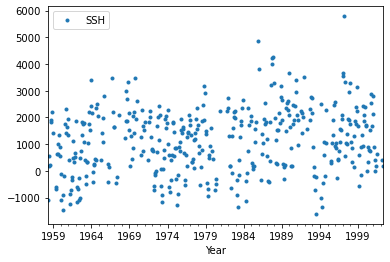

In [29]:
df_monthly.plot.line(y='SSH', linestyle='',marker='.')

### now calculate trend and compare to Spada

Trend = 2.09 mm/yr
                            OLS Regression Results                            
Dep. Variable:                    SSH   R-squared:                       0.043
Model:                            OLS   Adj. R-squared:                  0.041
Method:                 Least Squares   F-statistic:                     18.48
Date:                Wed, 08 Jul 2020   Prob (F-statistic):           2.15e-05
Time:                        12:07:38   Log-Likelihood:                -3495.3
No. Observations:                 412   AIC:                             6995.
Df Residuals:                     410   BIC:                             7003.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        719.6906    115.347 

Text(0.5, 0.98, 'ta')

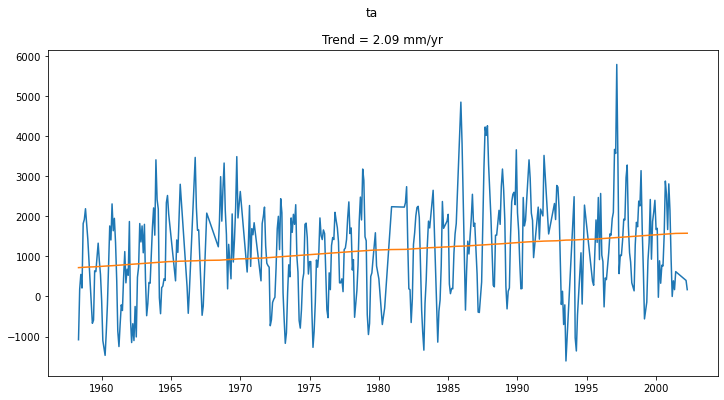

In [30]:
from tidegauge_functions import calc_OLS_tides

res = calc_OLS_tides(df_monthly, 'SSH')
trend = res.params.x1

print(f"Trend = {trend * 1:.2f} mm/yr")

print(res.summary())

fig, ax = plt.subplots(1, 1, figsize=(12,6));
ax.plot(df_monthly['SSH'].dropna().index, df_monthly['SSH'].dropna().values, label='trend')
ax.plot(df_monthly['SSH'].dropna().index, [res.params.x1*i + res.params.const for i in np.arange(len(df_monthly['SSH'].dropna()))])
# ax[1].plot(df['Vertical'].dropna().index, res.resid.values);
# ax[1].plot(df['Vertical'].dropna().index, np.abs(res.resid.values));
# ax[1].hlines(0, 0, len(res.resid), color='k');
ax.set_title(f"Trend = {res.params.x1 * 1:.2f} mm/yr");
# ax[1].set_title("Residuals");
plt.suptitle(f"{filepath[-21:4]}")
# plt.savefig(f'figs/test_GPS_OLS_{file_in[:4]}.png')